In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

print(tf.__version__)

2023-06-26 15:09:41.547294: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 15:09:42.025918: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [3]:
import keras_tuner as kt
from datetime import datetime

In [4]:
from eggman.grid import luminosity, log_surface_gravity, calculate_eep

In [5]:
filename = "/mnt/data-storage/yaguangli2023/stellar-models/grid_models_surface_effect_uncorrected/grid.h5"
tracks = pd.read_hdf(filename, "tracks")
tracks.head()

star_mass     Yinit     Zinit      amlt  fov_core  fov_shell
track                                                              
7000     0.92329  0.279311  0.001829  1.608258  0.000000   0.006041
7001     1.72329  0.229311  0.010871  2.308258  0.012396   0.006041
7002     2.12329  0.304311  0.004172  2.658258  0.015861   0.006041
7003     1.32329  0.254311  0.024469  1.958258  0.002481   0.006041
7004     1.12329  0.291811  0.006519  2.133258  0.000000   0.006041

In [6]:
stars = pd.read_hdf(filename, "stars")
stars.head()

star_age    radius         Teff  center_h1    log_LHe  \
track star                                                              
7000  1     2.220454e+07  0.893151  6382.509287   0.718192 -45.291905   
      2     2.300916e+07  0.891027  6377.312552   0.718122 -45.308912   
      3     2.397470e+07  0.890320  6373.785487   0.718037 -45.328570   
      4     3.019433e+07  0.893682  6371.412400   0.717474 -45.392646   
      5     3.259691e+07  0.894573  6371.453759   0.717253 -45.402736   

            log_Lnuc  Dnu_freq_o     eps_o  delta_Pg  
track star                                            
7000  1     0.078416  148.565794  1.129515       0.0  
      2     0.077135  149.148739  1.131800       0.0  
      3     0.075916  149.362908  1.132830       0.0  
      4     0.075178  148.552167  1.130613       0.0  
      5     0.075810  148.331713  1.129892       0.0

In [7]:
grid = tracks.join(stars).reset_index()
grid.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius         Teff  center_h1    log_LHe  log_Lnuc  \
0  2.220454e+07  0.893151  6382.509287   0.718192 -45.291905  0.078416   
1  2.300916e+07  0.891027  6377.312552   0.718122 -45.308912  0.077135   
2  2.397470e+07  0.890320  6373.785487   0.718037 -45.328570  0.075916   
3  3.019433e+07  0.893682  6371.412400   0.717474 -45.392646  0.075178   
4  3.259691e+07  0.894573  6371.453759   0.717253 -45.402736  0.075810   

   Dnu_freq_o     eps_o  delta_Pg  
0  148.565794  1.129515       0.0  
1  149.148739  1.131800       0.0  
2  149.362908  1.132830       0.0  
3  148.552167  1.130613       0.0  
4  148.331713  1.129892       0.0

In [8]:
grid["log_Zinit"] = np.log10(grid.Zinit)
grid["log_age"] = np.log10(grid.star_age)

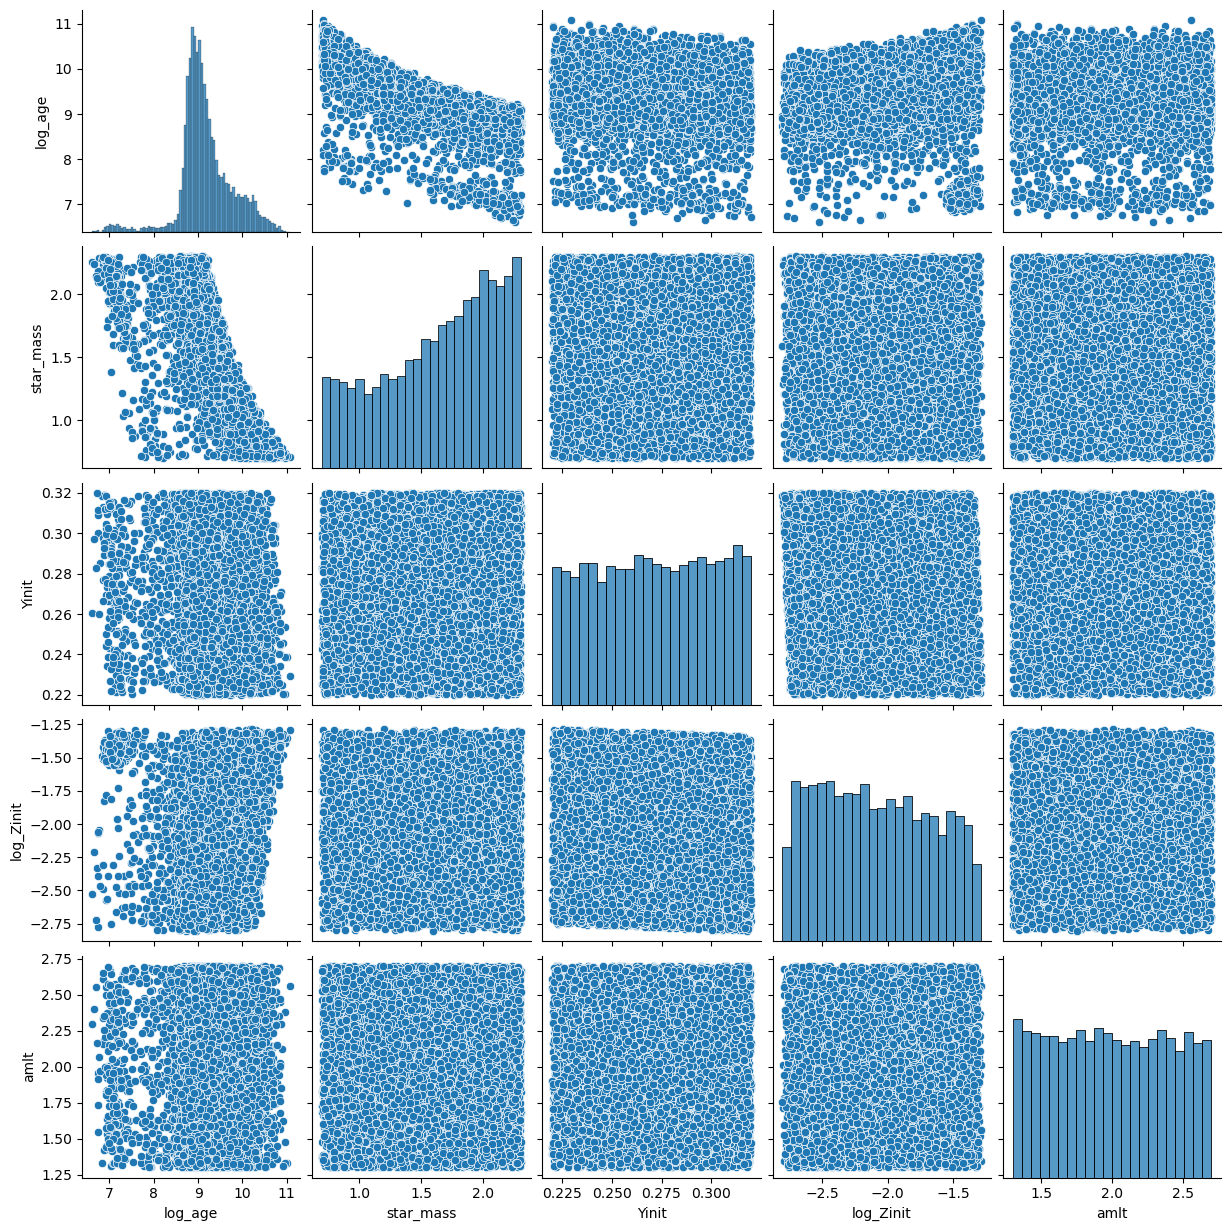

In [9]:
vars = ["log_age", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(grid.sample(10000), vars=vars);

The data needs some cleaning, there are low age patches.

In [10]:
grid["log_Teff"] = np.log10(grid.Teff)
grid["log_R"] = np.log10(grid.radius)
grid["log_Dnu"] = np.log10(grid.Dnu_freq_o)

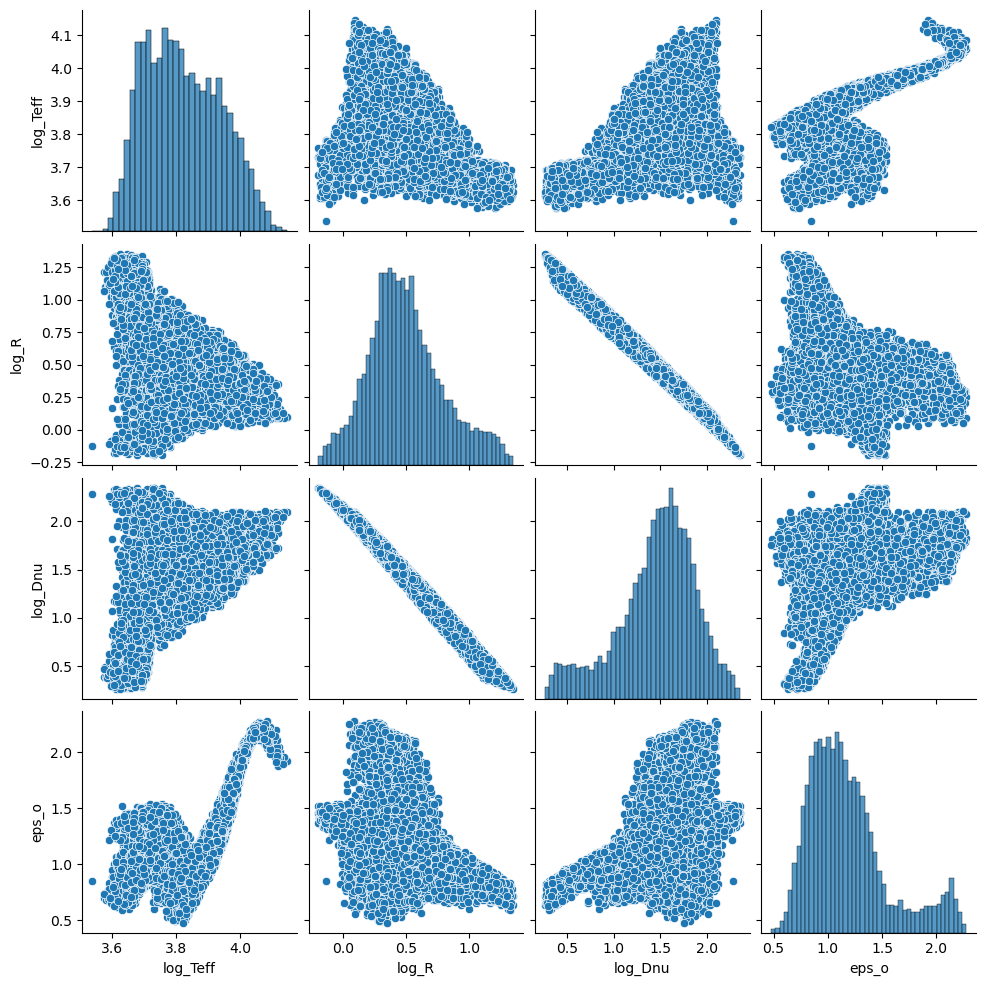

In [11]:
vars = ["log_Teff", "log_R", "log_Dnu", "eps_o"]
sns.pairplot(grid.sample(10000), vars=vars);

In [12]:
data = grid.dropna()
data.head()

track  star  star_mass     Yinit     Zinit      amlt  fov_core  fov_shell  \
0   7000     1    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
1   7000     2    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
2   7000     3    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
3   7000     4    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   
4   7000     5    0.92329  0.279311  0.001829  1.608258       0.0   0.006041   

       star_age    radius  ...    log_LHe  log_Lnuc  Dnu_freq_o     eps_o  \
0  2.220454e+07  0.893151  ... -45.291905  0.078416  148.565794  1.129515   
1  2.300916e+07  0.891027  ... -45.308912  0.077135  149.148739  1.131800   
2  2.397470e+07  0.890320  ... -45.328570  0.075916  149.362908  1.132830   
3  3.019433e+07  0.893682  ... -45.392646  0.075178  148.552167  1.130613   
4  3.259691e+07  0.894573  ... -45.402736  0.075810  148.331713  1.129892   

   delta_Pg  log_Zinit   log_age  log_Teff     log_R   log_Dnu  
0       0.0  -2.737812  7.346442  3.804991 -0.049075  2.171919  
1       0.0  -2.737812  7.361901  3.804638 -0.050109  2.173620  
2       0.0  -2.737812  7.379753  3.804397 -0.050454  2.174243  
3       0.0  -2.737812  7.479925  3.804236 -0.048817  2.171879  
4       0.0  -2.737812  7.513176  3.804239 -0.048384  2.171234  

[5 rows x 22 columns]

In [13]:
data["log_g"] = log_surface_gravity(data)
data["log_L"] = np.log10(luminosity(data))

In [14]:
with open("central_hydrogen_problem_tracks.txt") as file:
    bad = list(map(int, file.read().split(",")))

In [15]:
data = data.drop(index=data[data.track.isin(bad)].index)

In [16]:
phase, _ = calculate_eep(data)
data["phase"] = phase

In [17]:
data = data.drop(index=data[data.phase == -1].index)
data

track  star  star_mass     Yinit     Zinit      amlt  fov_core  \
4         7000     5    0.92329  0.279311  0.001829  1.608258       0.0   
5         7000     6    0.92329  0.279311  0.001829  1.608258       0.0   
6         7000     7    0.92329  0.279311  0.001829  1.608258       0.0   
7         7000     8    0.92329  0.279311  0.001829  1.608258       0.0   
8         7000     9    0.92329  0.279311  0.001829  1.608258       0.0   
...        ...   ...        ...       ...       ...       ...       ...   
6587233   4999   480    0.99087  0.316689  0.036025  1.923737       0.0   
6587234   4999   481    0.99087  0.316689  0.036025  1.923737       0.0   
6587235   4999   482    0.99087  0.316689  0.036025  1.923737       0.0   
6587236   4999   483    0.99087  0.316689  0.036025  1.923737       0.0   
6587237   4999   484    0.99087  0.316689  0.036025  1.923737       0.0   

         fov_shell      star_age     radius  ...  log_Zinit    log_age  \
4         0.006041  3.259691e+07   0.894573  ...  -2.737812   7.513176   
5         0.006041  3.548000e+07   0.895385  ...  -2.737812   7.549984   
6         0.006041  4.309136e+07   0.896934  ...  -2.737812   7.634390   
7         0.006041  5.405171e+07   0.898494  ...  -2.737812   7.732809   
8         0.006041  6.983463e+07   0.900101  ...  -2.737812   7.844071   
...            ...           ...        ...  ...        ...        ...   
6587233   0.006041  1.446116e+10  11.974001  ...  -1.443394  10.160203   
6587234   0.006041  1.446395e+10  12.438793  ...  -1.443394  10.160287   
6587235   0.006041  1.446496e+10  12.619153  ...  -1.443394  10.160317   
6587236   0.006041  1.446593e+10  12.798060  ...  -1.443394  10.160346   
6587237   0.006041  1.446687e+10  12.979214  ...  -1.443394  10.160375   

         log_Teff     log_R   log_Dnu     log_g     log_L   delta_X     f_nuc  \
4        3.804239 -0.048384  2.171234  4.500174  0.074879  0.001608  1.002145   
5        3.804235 -0.047990  2.170650  4.499387  0.075651  0.001875  1.001741   
6        3.804211 -0.047240  2.169543  4.497885  0.077058  0.002592  1.001313   
7        3.804184 -0.046485  2.168433  4.496376  0.078459  0.003644  1.000889   
8        3.804177 -0.045709  2.167280  4.494823  0.079984  0.005195  1.000489   
...           ...       ...       ...       ...       ...       ...       ...   
6587233  3.622522  1.078239  0.496672  2.277606  1.601259  0.647286  0.994609   
6587234  3.620797  1.094778  0.471924  2.244528  1.627438  0.647286  0.994784   
6587235  3.620149  1.101030  0.462585  2.232024  1.637351  0.647286  0.994722   
6587236  3.619526  1.107144  0.453453  2.219796  1.647086  0.647286  0.994695   
6587237  3.618881  1.113248  0.444344  2.207588  1.656715  0.647286  0.994695   

         phase  
4            0  
5            0  
6            0  
7            0  
8            0  
...        ...  
6587233      3  
6587234      3  
6587235      3  
6587236      3  
6587237      3  

[6228873 rows x 27 columns]

<Axes: ylabel='Frequency'>

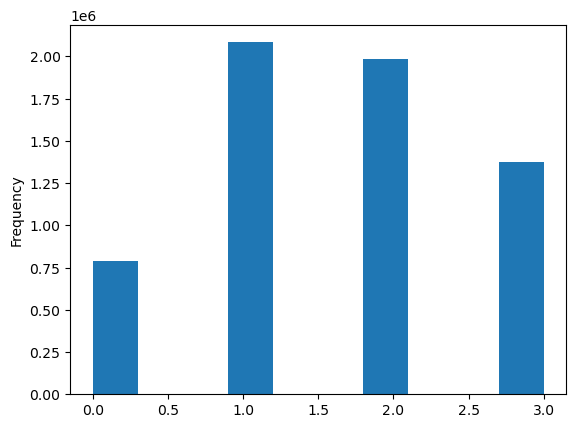

In [18]:
data.phase.plot(kind="hist")

In [19]:
ts = grid.track.sample(50)
mask = grid.track.isin(ts)

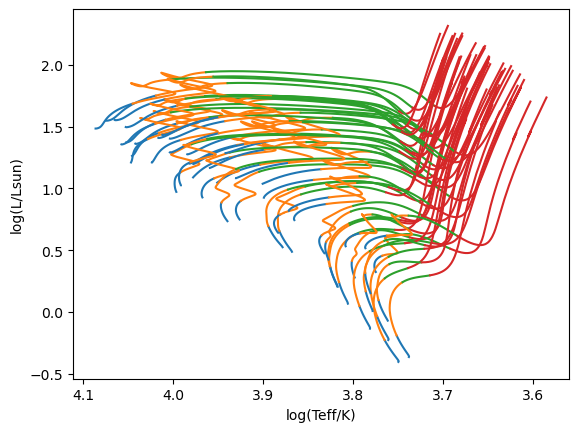

In [20]:
fig, ax = plt.subplots()

for idx, group in data.loc[mask].groupby(["track", "phase"], sort=False):
    label = None
    c = "gray" if idx[1] == -1 else f"C{idx[1]}"
    ax = group.plot(x="log_Teff", y="log_L", c=c, ax=ax, label=label)
#     ax.text(group.Teff.iloc[0], group.luminosity.iloc[0], idx[0])

ax.invert_xaxis()
# ax.invert_yaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")
# ax.legend(title="M, Yinit, Zinit, amlt")
ax.get_legend().remove()

In [21]:
# dist = pd.Series(np.nan, index=data.index)
eep = pd.Series(np.nan, index=data.index)

eep_keys = ["log_Teff", "log_L", "log_age"]
# eep_keys = ["log_age", "log_Teff", "log_Dnu"]
# weights = np.array([10., 1., 2.])
weights = np.ones(len(eep_keys))
alpha = 0.2
phases = [[0], [1], [2], [3]]
scale = [1, 1, 1, 1]
loc = [sum(scale[:i]) for i in range(len(scale))]
    
for _, group in data.groupby("track"):
    di = ((weights*group[eep_keys].diff()**2).sum(axis=1)**alpha).cumsum()
#     dist.loc[group.index] = di / di.max()

    for i, p in enumerate(phases):
        idx = group[group.phase.isin(p)].index
        lower = idx[0]
        upper = group[group.phase.isin(phases[i+1])].index[0] if i+1 < len(phases) else group.index[-1]
        eep.loc[idx] = loc[i] + scale[i] * (di.loc[idx] - di.loc[lower]) / (di.loc[upper] - di.loc[lower])

In [22]:
data["EEP"] = eep
data["EEP"]

4          0.000000
5          0.017941
6          0.042945
7          0.069534
8          0.097459
             ...   
6587233    3.974897
6587234    3.983205
6587235    3.988839
6587236    3.994431
6587237    4.000000
Name: EEP, Length: 6228873, dtype: float64

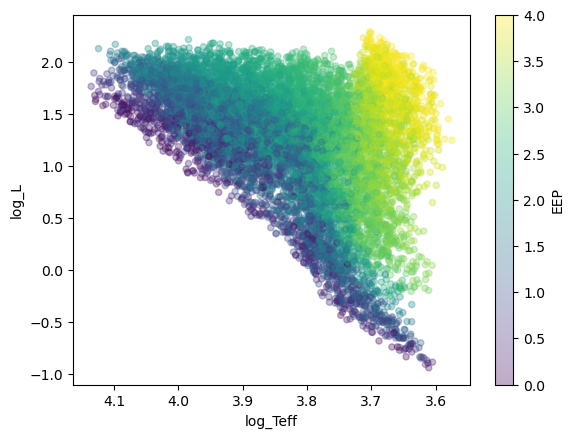

In [23]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="EEP", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

In [24]:
data["kron"] = data["star_age"] * data["star_mass"]**3.2
data["log_kron"] = np.log10(data["kron"])

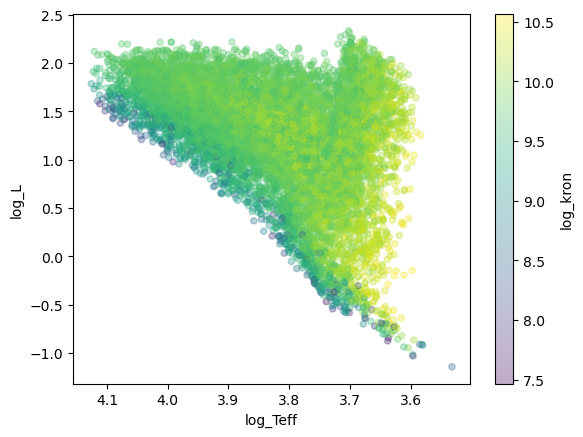

In [25]:
ax = data.sample(10000).plot(x="log_Teff", y="log_L", c="log_kron", cmap="viridis", kind="scatter", alpha=0.33)
ax.invert_xaxis()

In [26]:
data.EEP.isna().any()

False

In [27]:
data.log_kron.isna().any()

False

In [28]:
rstate = 0
train = data.sample(frac=0.8, random_state=rstate)
test = data.drop(index=train.index)

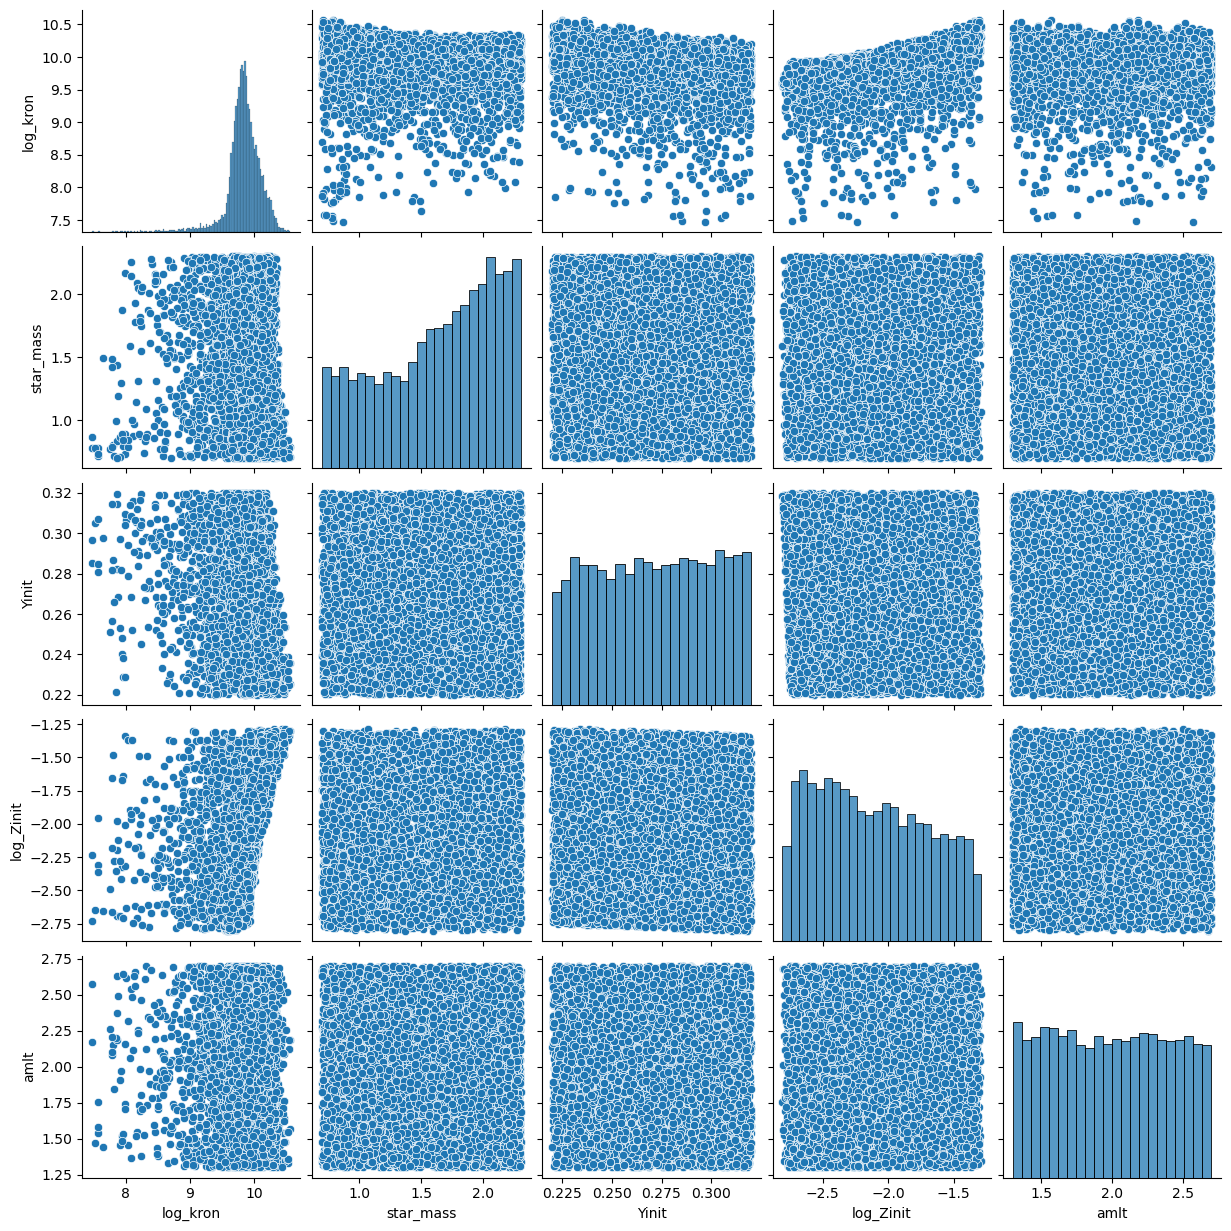

In [29]:
# features = ["log_kron", "star_mass", "Yinit", "log_Zinit", "amlt"]
# sns.pairplot(train.sample(10000), vars=features);

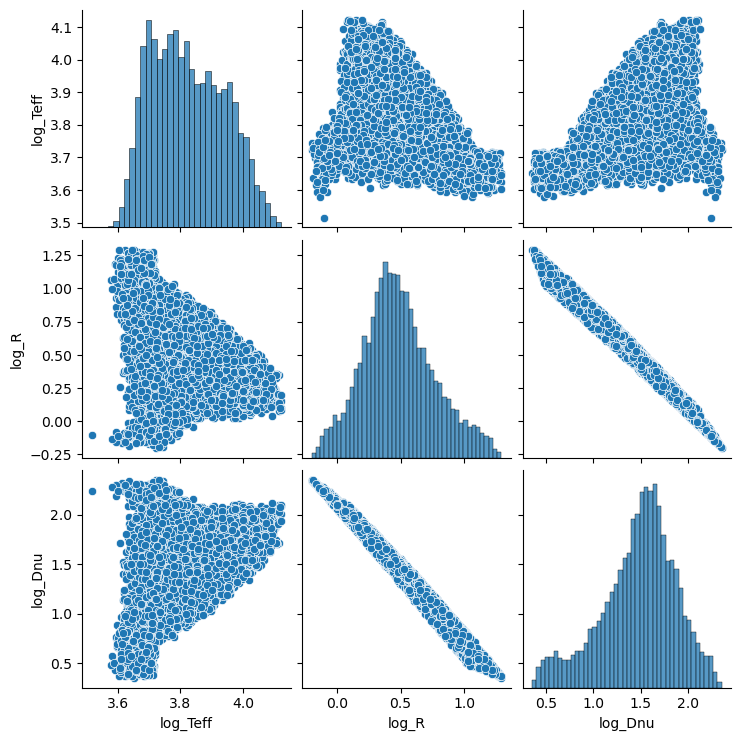

In [30]:
# labels = ["log_Teff", "log_R", "log_Dnu"]
# sns.pairplot(train.sample(10000), vars=labels);

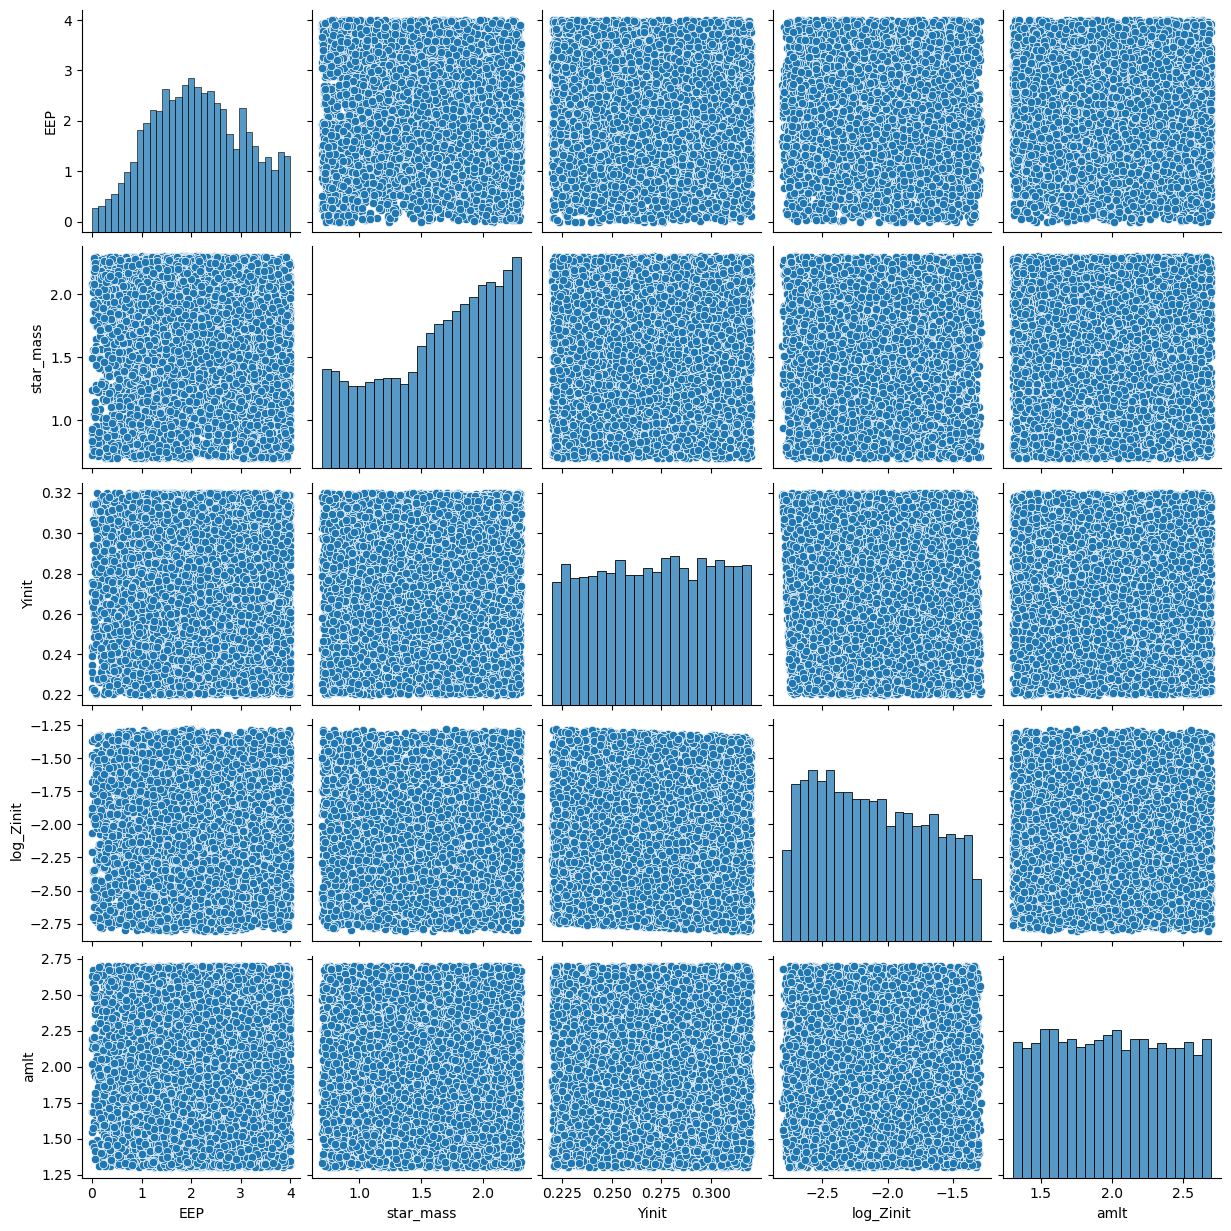

In [43]:
features = ["EEP", "star_mass", "Yinit", "log_Zinit", "amlt"]
sns.pairplot(train.sample(10000), vars=features);

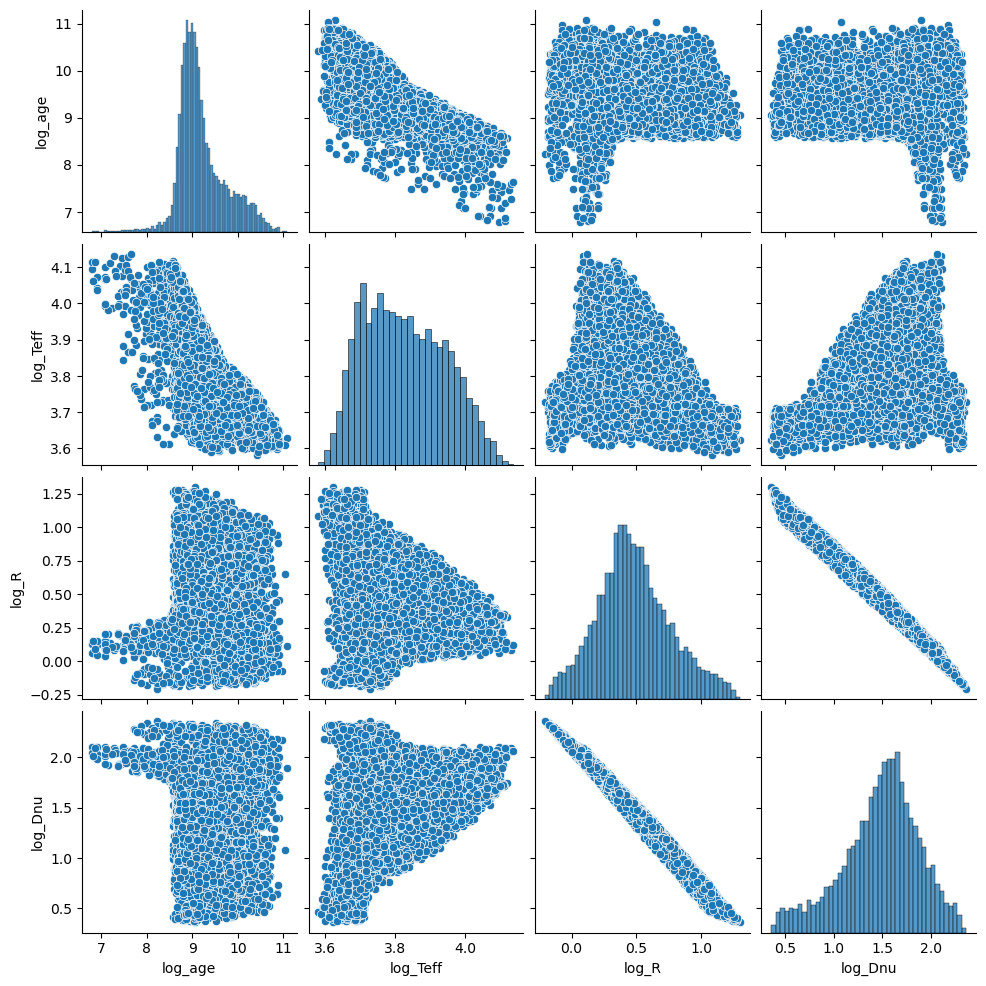

In [44]:
labels = ["log_age", "log_Teff", "log_R", "log_Dnu"]
sns.pairplot(train.sample(10000), vars=labels);

In [45]:
train_features = train[features].astype(np.float32).copy()
test_features = test[features].astype(np.float32).copy()

train_labels = train[labels].astype(np.float32).copy()
test_labels = test[labels].astype(np.float32).copy()

In [46]:
normalizer = layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features), batch_size=len(train_features))

In [47]:
label_offset = train_labels.mean().to_numpy()
label_scale = train_labels.std().to_numpy()

rescaler = layers.Rescaling(label_scale, offset=label_offset)

In [48]:
num_features = len(features)
num_labels = len(labels)

In [78]:
class HyperModel(kt.HyperModel):
    def __init__(self, *args, max_iter=100000, **kwargs):
        super().__init__(*args, **kwargs)
        self.max_iter = max_iter
        self.batch_size = None
        self.shuffle = None

    def build(self, hp):
        self.batch_size = hp.Choice("batch_size", values=[2**i for i in range(8, 18, 2)])
        self.shuffle = hp.Boolean("shuffle")

        units = hp.Choice('units_per_layer', values=[2**i for i in range(5, 10)])
        num_layers = hp.Int("hidden_layers", min_value=2, max_value=8, step=1)
        activation = "elu"
        
        model = tf.keras.Sequential(
            [normalizer] +
            [layers.Dense(units, activation) for _ in range(num_layers)] +
            [layers.Dense(num_labels), rescaler]
        )

        learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        opt = optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
        loss = 'mean_squared_error'

        model.compile(opt, loss=loss)
        return model

    def fit(self, hp, model, x, y, **kwargs):
#         batch_size = hp.Choice("batch_size", values=[2**i for i in range(8, 19, 2)])
        validation_split = kwargs.pop("validation_split", 0.0)
        epochs = kwargs.pop(
            "epochs",
            int(self.max_iter * self.batch_size / (1 - validation_split) / x.shape[0]) + 1
        )
        
        cbs = kwargs.pop("callbacks", [])
        if not any(isinstance(cb, callbacks.EarlyStopping) for cb in cbs):
            patience = max(3, int(0.05*epochs))
            early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=patience)
            cbs.append(early_stopping)

#         shuffle = hp.Boolean("shuffle")
        return model.fit(
            x=x,
            y=y,
            epochs=epochs,
            batch_size=self.batch_size,
            validation_split=validation_split,
            shuffle=self.shuffle,
            callbacks=cbs,
            **kwargs,
        )

In [91]:
hypermodel = HyperModel(max_iter=50000)

In [80]:
hp = kt.HyperParameters()
test_model = hypermodel.build(hp)

In [81]:
test_history = hypermodel.fit(
    hp,
    test_model,
    train_features,
    train_labels,
    epochs=1,
    validation_split=0.2
)

15573/15573 [==============================] - 38s 2ms/step - loss: 6.3541e-04 - val_loss: 3.7574e-04


In [82]:
train_pred = test_model(train_features)
log_error = train_labels - train_pred.numpy()

Text(0, 0.5, 'log(L/Lsun)')

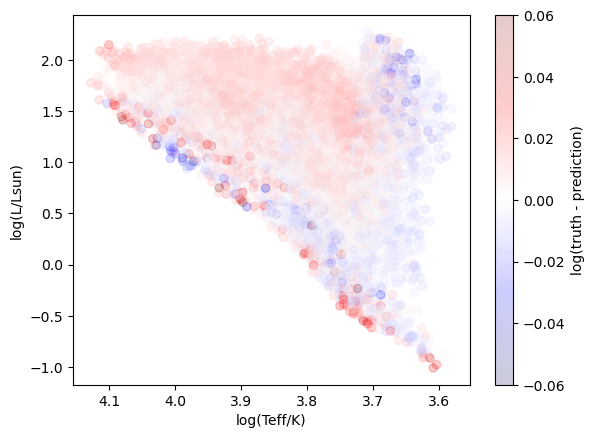

In [83]:
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.06, vmax=0.06)
fig.colorbar(s, label="log(truth - prediction)")

ax.invert_xaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")

In [85]:
directory = '/mnt/data-storage/stellar-emulator/tuning'
project_name = datetime.now().strftime("%Y%m%d-%H%M%S")

In [92]:
tuner = kt.BayesianOptimization(
    hypermodel,
    objective='val_loss',
    max_trials=50,
    directory=directory,
    project_name=project_name
)

INFO:tensorflow:Reloading Tuner from /mnt/data-storage/stellar-emulator/tuning/20230626-155006/tuner0.json


In [93]:
tboard = callbacks.TensorBoard(f'/mnt/data-storage/stellar-emulator/tuning/{project_name}/logs')

In [94]:
tuner.search(
    train_features,
    train_labels,
    validation_split=0.2,
    callbacks=[tboard]
)

Trial 41 Complete [00h 00m 51s]
val_loss: 0.00013445444346871227

Best val_loss So Far: 4.475362948141992e-05
Total elapsed time: 02h 02m 28s

Search: Running Trial #42

Value             |Best Value So Far |Hyperparameter
4096              |65536             |batch_size
False             |False             |shuffle
512               |256               |units_per_layer
2                 |4                 |hidden_layers
0.0001            |0.001             |learning_rate

Epoch 1/52
974/974 [==============================] - 4s 3ms/step - loss: 0.0135 - val_loss: 0.0073
Epoch 2/52
974/974 [==============================] - 3s 3ms/step - loss: 0.0053 - val_loss: 0.0032
Epoch 3/52
974/974 [==============================] - 3s 3ms/step - loss: 0.0021 - val_loss: 0.0015
Epoch 4/52
974/974 [==============================] - 3s 3ms/step - loss: 0.0012 - val_loss: 9.5090e-04
Epoch 5/52
974/974 [==============================] - 3s 3ms/step - loss: 7.8985e-04 - val_loss: 6.8168e-04
Epoch 6/52


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [95]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)

In [96]:
best_hp.values

{'batch_size': 65536,
 'shuffle': False,
 'units_per_layer': 256,
 'hidden_layers': 4,
 'learning_rate': 0.001}

In [62]:
epochs = 20

In [68]:
history = hypermodel.fit(
    best_hp,
    best_model,
    train_features, 
    train_labels, 
    epochs=20,
)

Epoch 1/20
4867/4867 [==============================] - 18s 3ms/step - loss: 0.0028
Epoch 2/20
4867/4867 [==============================] - 16s 3ms/step - loss: 2.0388e-04
Epoch 3/20
4867/4867 [==============================] - 15s 3ms/step - loss: 1.6784e-04
Epoch 4/20
4867/4867 [==============================] - 13s 3ms/step - loss: 1.5347e-04
Epoch 5/20
4867/4867 [==============================] - 13s 3ms/step - loss: 1.4355e-04
Epoch 6/20
4867/4867 [==============================] - 14s 3ms/step - loss: 1.3633e-04
Epoch 7/20
4867/4867 [==============================] - 16s 3ms/step - loss: 1.2888e-04
Epoch 8/20
4867/4867 [==============================] - 13s 3ms/step - loss: 1.2294e-04
Epoch 9/20
4867/4867 [==============================] - 14s 3ms/step - loss: 1.1767e-04
Epoch 10/20
4867/4867 [==============================] - 17s 4ms/step - loss: 1.1328e-04
Epoch 11/20
4867/4867 [==============================] - 17s 3ms/step - loss: 1.0856e-04
Epoch 12/20
4867/4867 [===========

In [70]:
num_points = 201
example_features = np.stack([
    np.linspace(0, 4, num_points),
    np.ones(num_points) * 1.0,
    np.ones(num_points) * 0.26,
    np.ones(num_points) * -2,
    np.ones(num_points) * 2,
], axis=-1)

example_labels = best_model(example_features).numpy()

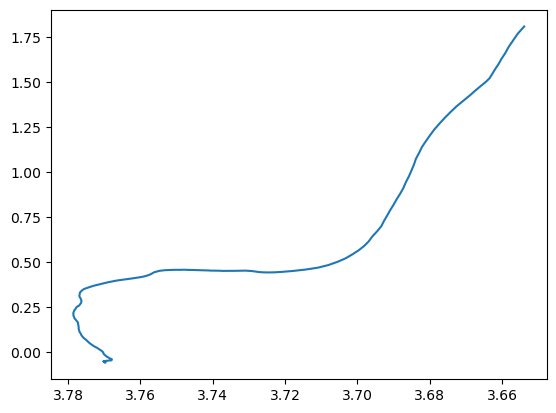

In [71]:
fig, ax = plt.subplots()


log_L = 2 * example_labels[:, 2] + 4 * (example_labels[:, 1] - np.log10(5772.))
ax.plot(example_labels[:, 1], log_L)
ax.invert_xaxis()

In [72]:
train_pred = best_model(train_features)
log_error = train_labels - train_pred.numpy()

Text(0, 0.5, 'log(L/Lsun)')

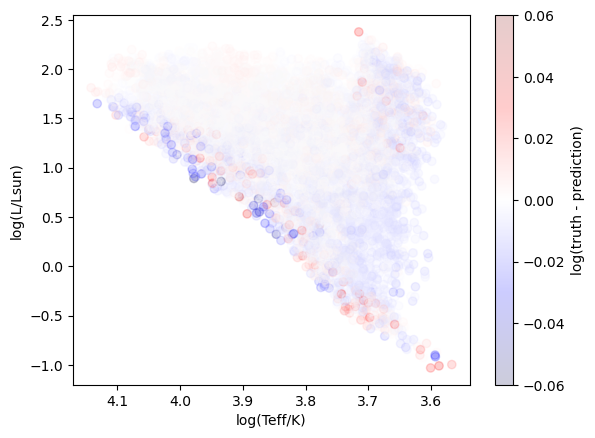

In [73]:
sample = train_labels.sample(10000)
fig, ax = plt.subplots()
s = ax.scatter(sample.log_Teff, data.loc[sample.index, "log_L"], c=log_error.loc[sample.index].mean(axis=1), 
               cmap="seismic", alpha=0.2, vmin=-0.06, vmax=0.06)
fig.colorbar(s, label="log(truth - prediction)")

ax.invert_xaxis()
ax.set_xlabel("log(Teff/K)")
ax.set_ylabel("log(L/Lsun)")

In [90]:
train_pred = pd.DataFrame(train_pred, index=train.index, columns=["log_age", "log_Teff", "log_R", "log_Dnu"])
train_pred["log_L"] = 2 * train_pred["log_R"] + 4 * (train_pred["log_Teff"] - np.log10(5772.))

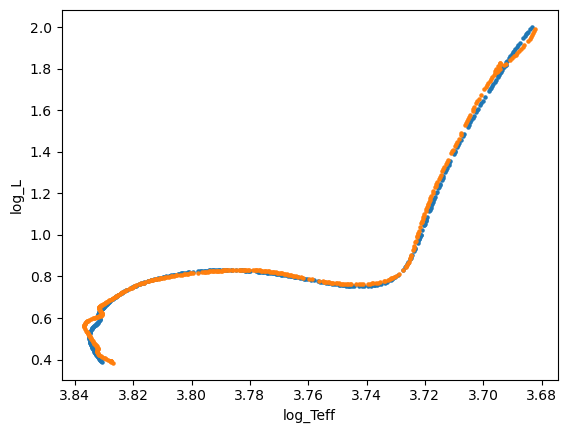

In [91]:
ti = 1084. # Arbitrary track
mask = train.track == ti
ax = train.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", marker=".")
ax = train_pred.loc[mask].plot(x="log_Teff", y="log_L", kind="scatter", c="C1", marker=".", ax=ax)

ax.invert_xaxis();

In [92]:
filepath = os.path.join(directory, project_name, "best", "model.tf")
best_model.save(filepath)

INFO:tensorflow:Assets written to: /mnt/data-storage/stellar-emulator/tuning/20230623-143022/best/model.tf/assets
